#Mini boucle 6 - Théorie des graphes optimisation

Participants :     
- Samuel : *Animateur*
- Thibaud : *Gestionnaire*
- Adonis : *Scribe*
- Rémi : *Secrétaire*
- Feernando : *Aucun rôle*

##Contexte :     
Optimation d'énergie des datacenters de SombraTech

##Problématique :     

Comment résoudre le problème de plannification de tâches des serveurs ?

##Objectif du projet :

Optimiser la plannification des tâches pour utiliser le trict minimum de serveurs pour optimiser la consommation d'énergie de SombraTech en trouvant le meilleur algorithme de graphe pour faire cela.

##Contraintes :      
- Utilisation de Python
- Graphe cordial, parfait
- Implémenter un parcours de graphes

##Livrables :     
- Notebook
- Scripts Python
- Graphes

Un **graphe** est une structure mathématique composée de :
- **Sommets (nœuds)** : les points représentant des entités (ici nos tâches)
- **Arêtes (liens)** : les connexions entre ces sommets (ici les chevauchements entre les différentes tâches)

**Notation mathématique** : G = (V, E)
- V = ensemble des sommets (Vertices)
- E = ensemble des arêtes (Edges)

##Coloration optimale
**Colorier un graphe** = attribuer une couleur à chaque sommet de sorte que **deux sommets adjacents n'aient jamais la même couleur**.

Dans notre projet, cela se traduit par le fait que 2 tâches se chevauchant vont être traitées par 2 serveurs différents, permettant de faire de l'optimisation

In [ ]:
#Librairies
import networkx as nx
import matplotlib.pyplot as plt
import csv
from collections import deque

%matplotlib inline

##Lecture des fichiers CSV

In [ ]:
def load_csv(nom_fichier): #Chargement CSV

    taches = {}
    with open(nom_fichier, 'r') as f:
        for ligne in csv.DictReader(f):
            taches[ligne['Task']] = (int(ligne['Start']), int(ligne['End']))
    return taches

taches = load_csv('task_intervals_1.csv')
print(f"{len(taches)} tâches chargées")
for t, (d, f) in taches.items():
    print(f"   {t}: [{d}, {f}]")

5 tâches chargées
   t0: [10, 20]
   t1: [25, 40]
   t2: [15, 30]
   t3: [38, 50]
   t4: [18, 39]


##Création d'un graphe d'intervalle

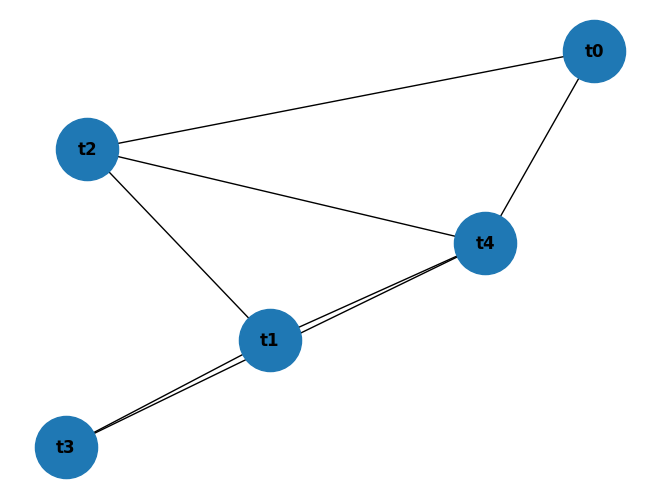

In [ ]:
def build_graph(taches): #Création du graph d'intervalle avec les chevauchements
    G = nx.Graph()
    G.add_nodes_from(taches.keys())

    # Ajouter une arête si les intervalles se chevauchent
    for t1, (d1, f1) in taches.items():
        for t2, (d2, f2) in taches.items():
            if t1 < t2 and d1 < f2 and d2 < f1:
                G.add_edge(t1, t2)

    return G

G = build_graph(taches)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, font_weight='bold', font_size=12)
plt.show()

##BFS (Breadth-First Search) - Parcours en Largeur

Le théorème de BFS sert à explorer un graph niveau par niveau (comme des vagues), de sort à trouver le chemin le plus court, donnant un ordre de parcours équilibré

In [ ]:
def BFS(graphe, depart): #Explore le graph par niveau avec BFS

    visites = set()
    file = deque([depart])
    ordre = []

    while file:
        sommet = file.popleft()
        if sommet not in visites:
            visites.add(sommet)
            ordre.append(sommet)
            for voisin in graphe.neighbors(sommet):
                if voisin not in visites and voisin not in file:
                    file.append(voisin)

    return ordre

##DFS (Depth-First Search) - Parcours en Profondeur

L'algorithme de DFS permet d'explorer un graphe en allant le plus loin possible, pour explorer toutes les possibilitées d'un graph.

###Comparaison
| Critère | BFS | DFS |
|---------|-----|-----|
| Exploration | Niveau par niveau | En profondeur |
| Chemin court | ✅ Garantit | ❌ Non garanti |

In [ ]:
def DFS(graphe, depart): #Explore le graph avec DFS (le plus loin possible)

    visites = set()
    pile = [depart]
    ordre = []

    while pile:
        sommet = pile.pop()
        if sommet not in visites:
            visites.add(sommet)
            ordre.append(sommet)
            for voisin in graphe.neighbors(sommet):
                if voisin not in visites:
                    pile.append(voisin)

    return ordre

##Test des parcours entre BFS et DFS

In [ ]:
# Test des parcours
depart = list(G.nodes())[0]
ordre_bfs = BFS(G, depart)
ordre_dfs = DFS(G, depart)

print(f"   BFS : {' → '.join(ordre_bfs)}")
print(f"   DFS : {' → '.join(ordre_dfs)}")

   BFS : t0 → t2 → t4 → t1 → t3
   DFS : t0 → t4 → t3 → t1 → t2


##Coloration

On va essayer de trouver le **nombre minimum de serveurs** pour traiter nos tâches avec l'**algorithme Glouton**.

##Algorithme Glouton
Cet algorithme sert à colorier un graphe rapidement. Il choisit la couleur d'un sommet un regardant la couleur des sommets voisins.


In [ ]:
def color_glouton(graphe, ordre): #Algorithme Glouton

    couleurs = {}

    for sommet in ordre:
        # Trouver les couleurs des voisins
        couleurs_voisins = {couleurs[v] for v in graphe.neighbors(sommet)
                           if v in couleurs}

        # Choisir la plus petite couleur disponible
        couleur = 0
        while couleur in couleurs_voisins:
            couleur += 1

        couleurs[sommet] = couleur

    return couleurs


##Comparaison de l'utilisation du théorème Glouton avec BFS et DFS

On va utiliser le théorème Glouton avec BFS et DFS et comparer pour voir lequel est le mieux optimiser en utilisant le moins de couleurs (et donc de serveurs).

In [ ]:
# Appliquer l'algorithme glouton avec différents ordres
ordre_defaut = list(G.nodes())
couleurs_bfs = color_glouton(G, ordre_bfs)
couleurs_dfs = color_glouton(G, ordre_dfs)
couleurs_defaut = color_glouton(G, ordre_defaut)

nb_bfs = len(set(couleurs_bfs.values()))
nb_dfs = len(set(couleurs_dfs.values()))
nb_defaut = len(set(couleurs_defaut.values()))

print(f"   Avec BFS : {nb_bfs} serveurs")
print(f"   Avec DFS : {nb_dfs} serveurs")
print(f"   Ordre par défaut : {nb_defaut} serveurs")

   Avec BFS : 3 serveurs
   Avec DFS : 4 serveurs
   Ordre par défaut : 3 serveurs


##Graphes pour comparer les différents parcours

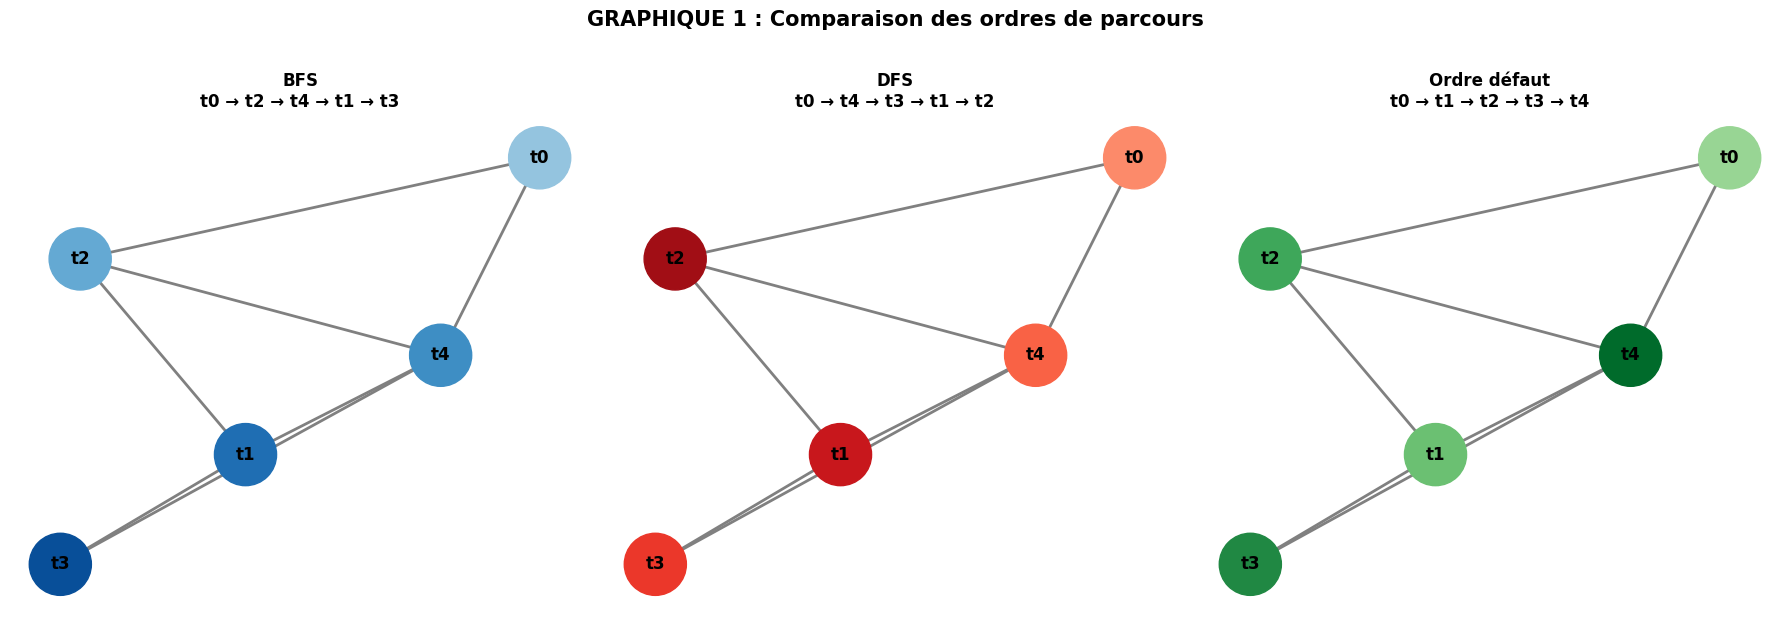

In [ ]:
fig = plt.figure(figsize=(18, 6))

# 1er graphe BFS
ax1 = plt.subplot(1, 3, 1)
couleurs_viz = [plt.cm.Blues(0.4 + 0.6 * ordre_bfs.index(n) / len(ordre_bfs))
                for n in G.nodes()]
nx.draw(G, pos, node_color=couleurs_viz, with_labels=True,
        node_size=2000, font_weight='bold', font_size=12,
        edge_color='gray', width=2, ax=ax1)
ax1.set_title(f"BFS\n{' → '.join(ordre_bfs)}", fontweight='bold', fontsize=12)

# 2e graphe : DFS
ax2 = plt.subplot(1, 3, 2)
couleurs_viz = [plt.cm.Reds(0.4 + 0.6 * ordre_dfs.index(n) / len(ordre_dfs))
                for n in G.nodes()]
nx.draw(G, pos, node_color=couleurs_viz, with_labels=True,
        node_size=2000, font_weight='bold', font_size=12,
        edge_color='gray', width=2, ax=ax2)
ax2.set_title(f"DFS\n{' → '.join(ordre_dfs)}", fontweight='bold', fontsize=12)

# 3e graphe - Ordre par défaut
ax3 = plt.subplot(1, 3, 3)
couleurs_viz = [plt.cm.Greens(0.4 + 0.6 * ordre_defaut.index(n) / len(ordre_defaut))
                for n in G.nodes()]
nx.draw(G, pos, node_color=couleurs_viz, with_labels=True,
        node_size=2000, font_weight='bold', font_size=12,
        edge_color='gray', width=2, ax=ax3)
ax3.set_title(f"Ordre défaut\n{' → '.join(ordre_defaut)}", fontweight='bold', fontsize=12)

plt.suptitle("GRAPHIQUE 1 : Comparaison des ordres de parcours",
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

##Graphes pour visualisaion les différents colorations

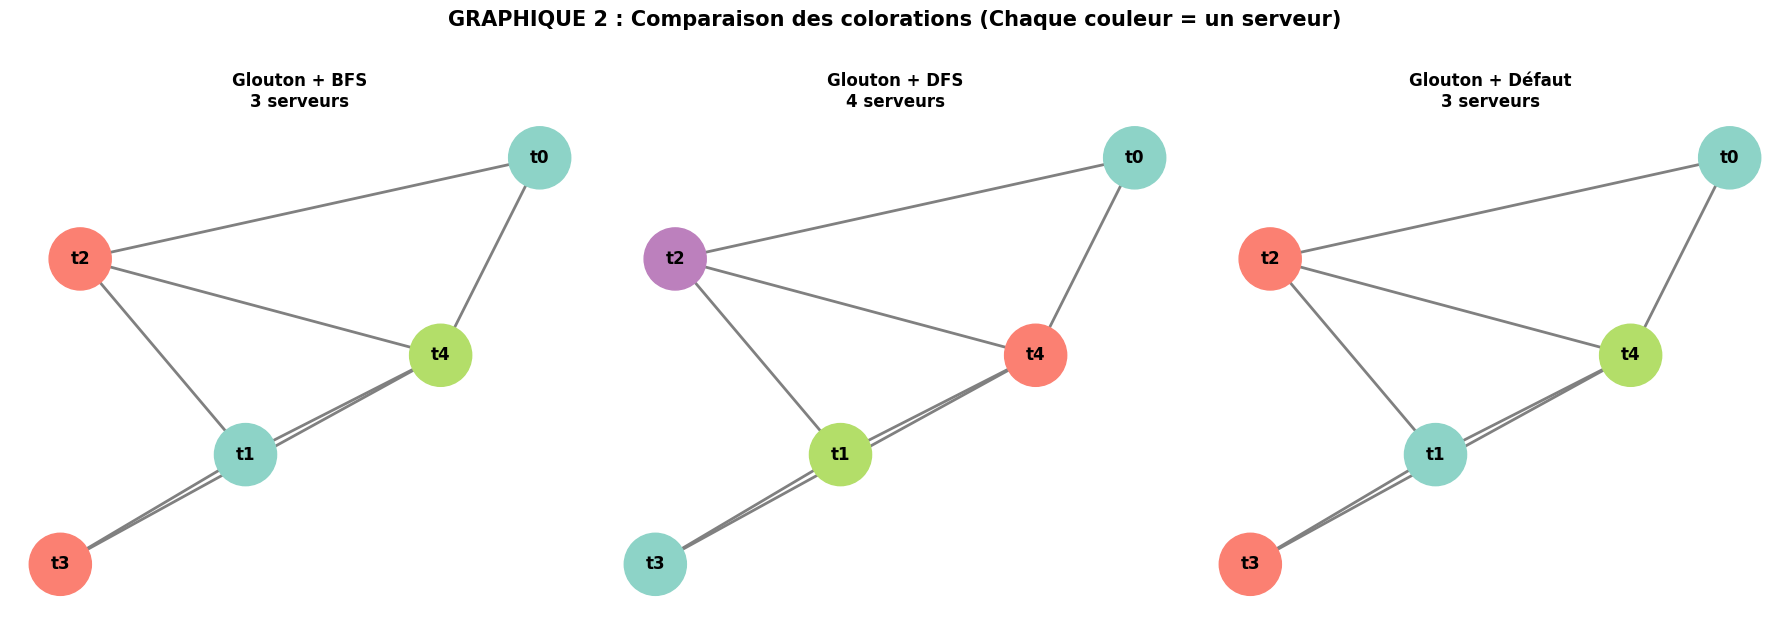

In [ ]:
fig = plt.figure(figsize=(18, 6))

# Graphe 1 : Coloration avec BFS
ax1 = plt.subplot(1, 3, 1)
couleurs_viz = [couleurs_bfs[n] for n in G.nodes()]
nx.draw(G, pos, node_color=couleurs_viz, with_labels=True,
        node_size=2000, font_weight='bold', font_size=12,
        cmap=plt.cm.Set3, vmin=0, vmax=4,
        edge_color='gray', width=2, ax=ax1)
ax1.set_title(f"Glouton + BFS\n{nb_bfs} serveurs", fontweight='bold', fontsize=12)

# Graphe 2 : Coloration avec DFS
ax2 = plt.subplot(1, 3, 2)
couleurs_viz = [couleurs_dfs[n] for n in G.nodes()]
nx.draw(G, pos, node_color=couleurs_viz, with_labels=True,
        node_size=2000, font_weight='bold', font_size=12,
        cmap=plt.cm.Set3, vmin=0, vmax=4,
        edge_color='gray', width=2, ax=ax2)
ax2.set_title(f"Glouton + DFS\n{nb_dfs} serveurs", fontweight='bold', fontsize=12)

# Graphe 3 : Coloration avec ordre par défaut
ax3 = plt.subplot(1, 3, 3)
couleurs_viz = [couleurs_defaut[n] for n in G.nodes()]
nx.draw(G, pos, node_color=couleurs_viz, with_labels=True,
        node_size=2000, font_weight='bold', font_size=12,
        cmap=plt.cm.Set3, vmin=0, vmax=4,
        edge_color='gray', width=2, ax=ax3)
ax3.set_title(f"Glouton + Défaut\n{nb_defaut} serveurs", fontweight='bold', fontsize=12)

plt.suptitle("GRAPHIQUE 2 : Comparaison des colorations (Chaque couleur = un serveur)",
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

##Meilleur résultat

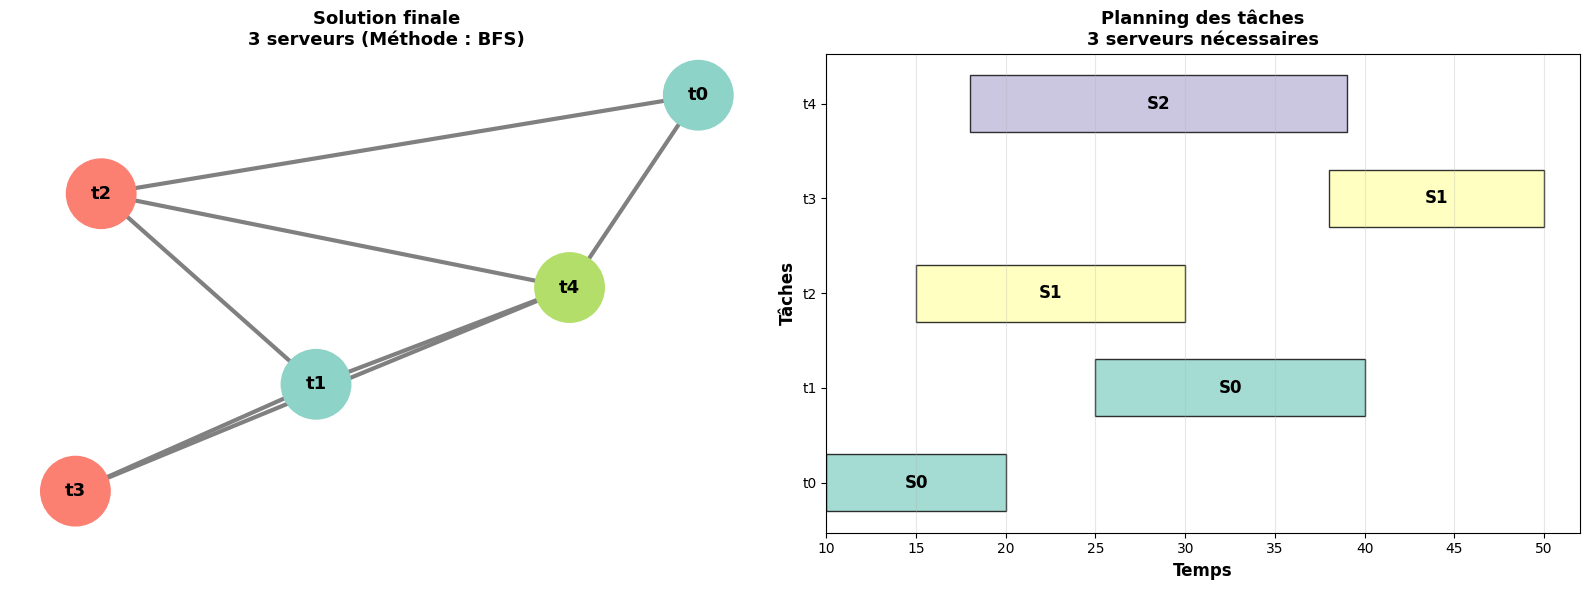

In [ ]:
# Choisir la meilleure solution (minimum de serveurs)
meilleure_solution = min([(nb_bfs, couleurs_bfs, "BFS"),
                          (nb_dfs, couleurs_dfs, "DFS"),
                          (nb_defaut, couleurs_defaut, "Défaut")],
                         key=lambda x: x[0])

nb_serveurs, couleurs_finales, methode = meilleure_solution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphe Final
couleurs_viz = [couleurs_finales[n] for n in G.nodes()]
nx.draw(G, pos, node_color=couleurs_viz, with_labels=True,
        node_size=2500, font_weight='bold', font_size=13,
        cmap=plt.cm.Set3, vmin=0, vmax=4,
        edge_color='gray', width=3, ax=ax1)
ax1.set_title(f"Solution finale\n{nb_serveurs} serveurs (Méthode : {methode})",
              fontweight='bold', fontsize=13)

# Visuel des tâches avec un Diagramme de Gantt
for i, (tache, (debut, fin)) in enumerate(taches.items()):
    serveur = couleurs_finales[tache]
    ax2.barh(tache, fin - debut, left=debut,
             color=plt.cm.Set3(serveur),
             edgecolor='black', height=0.6, alpha=0.8)
    ax2.text((debut + fin) / 2, i, f"S{serveur}",
             ha='center', va='center', fontweight='bold', fontsize=12)

ax2.set_xlabel('Temps', fontweight='bold', fontsize=12)
ax2.set_ylabel('Tâches', fontweight='bold', fontsize=12)
ax2.set_title(f'Planning des tâches\n{nb_serveurs} serveurs nécessaires',
              fontsize=13, fontweight='bold')
ax2.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

##Conclusion

L'utilisation en conjontion du théorème Glouton et de BFS est le mieux pour optimiser le plus facilement l'exécution de tâches sur différents serveurs et pouvoir économiser le mieux l'énergie.